# Generic hyperparameters

In [ ]:
dataset_split = 0.9

bs = 128

# All the images are 700x400 pixels, we resize keeping proportions
img_h = 146 
img_w = 256

SEED = 1234

# Libraries and Drive

In [ ]:
import os
import math
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from google.colab import drive
from datetime import datetime
from matplotlib import cm
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
cwd = os.getcwd()

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

#Data Loading

In [ ]:
dataset_dir = os.path.join(cwd, '/content/drive/My Drive/VQA/VQA_Dataset')

#Loading the json file into a pandas dataframe
df = pd.read_json(os.path.join(dataset_dir,"train_questions_annotations.json")).T

#Reshuffle
df = df.sample(frac=1).reset_index(drop=True)

print("Size of the whole dataset (questions):", len(df))

Size of the whole dataset (questions): 58832


In [ ]:
# Resize the whole image dataset once, to speed up training
# This cell executes only if resized dataset does not already exist

resize_whole_dataset = False

new_size = (256, 146)  

resized_folder_name = 'Images_256x146'
resized_images_dir = os.path.join('/content/drive/My Drive/VQA', resized_folder_name)
images_dir = '/content/drive/My Drive/VQA/VQA_Dataset/Images'
num_images = 29339

if resize_whole_dataset:

  if not os.path.exists(resized_images_dir):
      os.makedirs(resized_images_dir)

      i = 1
      for image_name in os.listdir(images_dir):
        img = Image.open(os.path.join(images_dir, image_name))
        img = img.resize(new_size)
        resized_img_path = os.path.join(resized_images_dir, image_name)
        img.save(resized_img_path)

        print('Processed images:', i, '/', num_images)
        i+=1

In [ ]:
load_images_in_RAM = False

# Storing images in RAM, to speed up training
# Too slow: 3 hours to load the entire dataset, over 12 max hours of one colab session 

if(load_images_in_RAM):

  images_RAM = {}

  i = 1
  for image_name in os.listdir(resized_images_dir):
    img = Image.open(os.path.join(resized_images_dir, image_name))
    img_arr = np.array(img)
    images_RAM[image_name] = img_arr
    print(i)

In [ ]:
classes = {
  '0': 0,
  '1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  'apple': 6,
  'baseball': 7,
  'bench': 8,
  'bike': 9,
  'bird': 10,
  'black': 11,
  'blanket': 12,
  'blue': 13,
  'bone': 14,
  'book': 15,
  'boy': 16,
  'brown': 17,
  'cat': 18,
  'chair': 19,
  'couch': 20,
  'dog': 21,
  'floor': 22,
  'food': 23,
  'football': 24,
  'girl': 25,
  'grass': 26,
  'gray': 27,
  'green': 28,
  'left': 29,
  'log': 30,
  'man': 31,
  'monkey bars': 32,
  'no': 33,
  'nothing': 34,
  'orange': 35,
  'pie': 36,
  'plant': 37,
  'playing': 38,
  'red': 39,
  'right': 40,
  'rug': 41,
  'sandbox': 42,
  'sitting': 43,
  'sleeping': 44,
  'soccer': 45,
  'squirrel': 46,
  'standing': 47,
  'stool': 48,
  'sunny': 49,
  'table': 50,
  'tree': 51,
  'watermelon': 52,
  'white': 53,
  'wine': 54,
  'woman': 55,
  'yellow': 56,
  'yes': 57
}
    
num_classes = len(classes)

##Data Preparation

In [ ]:
# Tokenization

tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)

questions = []
for index, row in df.iterrows():
  question = []
  question += row['question'].split(" ")
  question = [quest.replace("?", "") for quest in question]
  questions.append(question)

tokenizer.fit_on_texts(questions)
encoded_questions = tokenizer.texts_to_sequences(questions)

max_length = max(len(sequence) for sequence in encoded_questions)
words_number = len(tokenizer.word_index) + 1

# Padding

encoded_questions = tf.keras.preprocessing.sequence.pad_sequences(encoded_questions, maxlen=max_length) # Padding, to make every sequence having the same length


for i, row in df.iterrows():
  df.loc[i, "question"] = encoded_questions[i]
  df.loc[i, "answer"] = classes[row["answer"]]

In [ ]:
# Splitting the main dataframe in train_dataFrame (90% of the samples) and valid_dataFrame (10% of the samples).

train_dataFrame = pd.DataFrame()
valid_dataFrame = pd.DataFrame()

train_dataFrame = train_dataFrame.append(df.head(math.floor(len(df.index) * dataset_split)), ignore_index=True)
valid_dataFrame = valid_dataFrame.append(df.tail(len(df) - math.floor(len(df.index) * dataset_split)), ignore_index=True)

In [ ]:
# Custom image transformation

def custom_transformation(img_arr):

  # If using model_1 (VGG_LSTM_Dense) uncomment this: 
  '''rgb_transform = tf.keras.applications.vgg16.preprocess_input(img_arr[:,:,0:3])
  img_arr = np.dstack((rgb_transform,img_arr[:,:,3])) '''


  # If using model_2 (MobileNetV2_LSTM_Dense) uncomment this:
  '''rgb_transform = tf.keras.applications.mobilenet_v2.preprocess_input(img_arr[:,:,0:3])
  img_arr = np.dstack((rgb_transform,img_arr[:,:,3])) '''


  # If using model_3 (CNN_LSTM_Dense) uncomment this:
  img_arr = img_arr / 255.
  

  return img_arr

## Custom Data Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, dataFrame, img_size=(256,256), batch_size=16, max_length=22, shuffle=True, images_dir=None):
        
        self.dataFrame = dataFrame
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.max_length = max_length
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
      return int(np.floor(len(self.dataFrame) / self.batch_size)) # Number of batches

    def __getitem__(self, index):
      
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size : (index + 1)*self.batch_size]

      # Initialize batch
      X1 = np.empty((self.batch_size, self.img_size[1], self.img_size[0], 4))  # images (4? number of channels)
      X2 = np.empty((self.batch_size, self.max_length))                        # questions
      y = np.empty((self.batch_size, 1), dtype=int)                            # answers

      # Generate batch
      for i, ind in enumerate(indexes):
        
        curr_image =  self.dataFrame.loc[ind, "image_id"] + ".png" # Take the specific name of the image
        img = Image.open(os.path.join(images_dir, curr_image))
        img = img.resize(self.img_size) # If images have already the desired size, this instruction is automatically skipped 
        img_arr = np.array(img)

        img_arr = custom_transformation(img_arr) # Whatever is the proper transformation, it's specified in 'custom_transformation' function

        question = self.dataFrame.loc[ind, "question"]
        answer = self.dataFrame.loc[ind, "answer"]
        
        X1[i,] = img_arr
        X2[i,] = question
        y[i,] = answer

      input_data = [X1, X2]

      return input_data, y
   
    def on_epoch_end(self):
      self.indexes = np.arange(len(self.dataFrame))
      if self.shuffle == True:
         np.random.shuffle(self.indexes)

In [ ]:
# Training dataset
train_dataset = DataGenerator(dataFrame = train_dataFrame,
                              img_size = (img_w, img_h),
                              batch_size = bs,
                              max_length = max_length,
                              shuffle = True,
                              images_dir = '/content/drive/My Drive/VQA/Dataset/Images' # Already resized
                              )


# Validation dataset
valid_dataset = DataGenerator(dataFrame = valid_dataFrame,
                              img_size = (img_w, img_h),
                              batch_size = bs,
                              max_length = max_length,
                              shuffle = False,
                              images_dir = '/content/drive/My Drive/VQA/Dataset/Images'
                              )

## Data visualization

Input question: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  1. 22.  8. 21. 28. 95.
  1. 45.  9. 51.]
Label answer: [33]


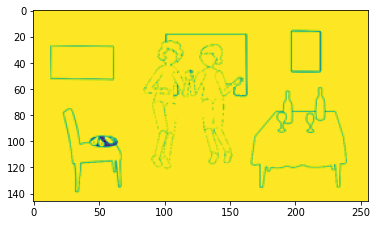

In [ ]:
# Show one img-question-answer from the generated dataset, to check if everything is correct 

show_data_sample = True

index_in_batch = 0
color_channel = 3

if show_data_sample:
  iterator = iter(train_dataset)

  input_data, y = next(iterator)

  plt.imshow(input_data[0][index_in_batch,:,:,color_channel])
  print("Input question:", input_data[1][index_in_batch])
  print("Label answer:", y[index_in_batch])

# Models

### model_1: VGG_LSTM_Dense

In [ ]:
def create_model_1():

    # Hyperparameters of this model

    num_image_features = 64
    embedding_size = 64

    lstm_units = 100
    lstm_dropout = 0.2
  
    dense_units = 128
    dense_dropout = 0.2


    # CNN for images: pretrained VGG

    vgg_model = tf.keras.applications.VGG16(input_shape=(img_h, img_w, 3), include_top=False, weights='imagenet')
    for i in range(len(vgg_model.layers)):
        vgg_model.layers[i].trainable = False
    
    vision_model = tf.keras.models.Sequential()

    vision_model.add(vgg_model)

    vision_model.add(tf.keras.layers.Dropout(0.1))
    vision_model.add(tf.keras.layers.Flatten())
    vision_model.add(tf.keras.layers.Dense(num_image_features))

    image_input = tf.keras.layers.Input(shape=(img_h, img_w, 4))
    image_rgb_only = tf.keras.layers.Lambda(lambda x: x[:,:,:,0:3], output_shape=(img_h, img_w, 3))(image_input)
    encoded_image = vision_model(image_rgb_only) # VGG ignores the 4th channel of the image


    # RNN for questions: LSTM

    question_input = tf.keras.layers.Input(shape=[max_length])
    embedded_question = tf.keras.layers.Embedding(input_dim=words_number, output_dim=embedding_size, input_length=max_length, mask_zero=True)(question_input)
    encoded_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, unroll=True))(embedded_question)


    # Combine CNN and RNN

    merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
    output = tf.keras.layers.Dense(dense_units)(merged)
    output = tf.keras.layers.Dropout(dense_dropout)(output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)
    model_1 = tf.keras.models.Model(inputs=[image_input, question_input], outputs=output)
    
    return model_1

### model_2: MobileNetV2_LSTM_Dense

In [ ]:
def create_model_2():

    # Hyperparameters of this model

    num_image_features = 64
    embedding_size = 32

    lstm_units = 64
    lstm_dropout = 0.2
  
    dense_units = 256
    dense_dropout = 0.2


    # CNN for images: pretrained MobileNetV2

    mobilenetv2_model = tf.keras.applications.MobileNetV2(input_shape=(img_h, img_w, 3), include_top=False, weights='imagenet')
    for i in range(len(mobilenetv2_model.layers)):
        mobilenetv2_model.layers[i].trainable = False
    
    vision_model = tf.keras.models.Sequential()

    vision_model.add(mobilenetv2_model)

    vision_model.add(tf.keras.layers.Dropout(0.1))
    vision_model.add(tf.keras.layers.Flatten())
    vision_model.add(tf.keras.layers.Dense(num_image_features))

    image_input = tf.keras.layers.Input(shape=(img_h, img_w, 4))
    image_rgb_only = tf.keras.layers.Lambda(lambda x: x[:,:,:,0:3], output_shape=(img_h, img_w, 3))(image_input)
    encoded_image = vision_model(image_rgb_only) # MobileNetV2 ignores the 4th channel of the image


    # RNN for questions: LSTM

    question_input = tf.keras.layers.Input(shape=[max_length])
    embedded_question = tf.keras.layers.Embedding(input_dim=words_number, output_dim=embedding_size, input_length=max_length, mask_zero=True)(question_input)
    encoded_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, unroll=True))(embedded_question)

    # Combine CNN and RNN

    merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
    output = tf.keras.layers.Dense(dense_units)(merged)
    output = tf.keras.layers.Dropout(dense_dropout)(output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)
    model_2 = tf.keras.models.Model(inputs=[image_input, question_input], outputs=output)
    
    return model_2

### model_3: CNN_LSTM_Dense (best)

In [ ]:
def create_model_3():

    # Hyperparameters of this model

    num_image_features = 64
    embedding_size = 64

    lstm_units = 100
    lstm_dropout = 0.2
  
    dense_units = 128
    dense_dropout = 0.2


    # CNN for images

    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=[img_h, img_w, 4]))
    cnn_model.add(tf.keras.layers.ReLU())
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    cnn_model.add(tf.keras.layers.ReLU())
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))    
    cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    cnn_model.add(tf.keras.layers.ReLU())
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    cnn_model.add(tf.keras.layers.ReLU())
    cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Flatten())


    vision_model = tf.keras.models.Sequential()

    vision_model.add(cnn_model)

    vision_model.add(tf.keras.layers.Dropout(0.1))
    vision_model.add(tf.keras.layers.Flatten())
    vision_model.add(tf.keras.layers.Dense(num_image_features))

    image_input = tf.keras.layers.Input(shape=(img_h, img_w, 4))
    encoded_image = vision_model(image_input)


    # RNN for questions: LSTM

    question_input = tf.keras.layers.Input(shape=[max_length])
    embedded_question = tf.keras.layers.Embedding(input_dim=words_number, output_dim=embedding_size, input_length=max_length, mask_zero=True)(question_input)
    encoded_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, unroll=True))(embedded_question)


    # Combine CNN and RNN

    merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
    output = tf.keras.layers.Dense(dense_units)(merged)
    output = tf.keras.layers.Dropout(dense_dropout)(output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)
    model_3 = tf.keras.models.Model(inputs=[image_input, question_input], outputs=output)
    
    return model_3

In [ ]:
model_3 = create_model_3()

In [ ]:
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 22, 64)       308352      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 146, 256, 4) 0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200)          132000      embedding[0][0]                  
______________________________________________________________________________________________

## Compiling

In [ ]:
# Learning rate

lr = 5e-4


# Optimization choices

loss = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='s_c_acc', dtype=None)

model_3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Tensorboard + Callbacks

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/My Drive/VQA/experiments"

In [ ]:
exps_dir = os.path.join('/content/drive/My Drive/VQA', 'experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN_LSTM_Dense'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    callbacks.append(es_callback)

# Training

In [ ]:
# First fit. lr = 5e-4. Interrupted because Colab session expired.

history = model_3.fit(x = train_dataset,
                      epochs = 30,
                      validation_data = valid_dataset,
                      callbacks = callbacks)

In [ ]:
model_3.load_weights("/content/drive/My Drive/VQA/experiments/VGG_LSTM_Dense_Jan28_23-41-58/ckpts/cp_06.ckpt")

In [ ]:
# Second fit. lr = 2e-4

history2 = model_3.fit(x = train_dataset,
                      epochs = 30,
                      validation_data = valid_dataset,
                      callbacks = callbacks)

Epoch 1/30
413/413 [==============================] - 8229s 20s/step - loss: 0.8579 - s_c_acc: 0.6548 - val_loss: 1.0451 - val_s_c_acc: 0.5823
Epoch 2/30
413/413 [==============================] - 860s 2s/step - loss: 0.7631 - s_c_acc: 0.6920 - val_loss: 1.0778 - val_s_c_acc: 0.5840
Epoch 3/30
413/413 [==============================] - 857s 2s/step - loss: 0.6487 - s_c_acc: 0.7335 - val_loss: 1.1584 - val_s_c_acc: 0.5785
Epoch 4/30
413/413 [==============================] - 856s 2s/step - loss: 0.5414 - s_c_acc: 0.7751 - val_loss: 1.1892 - val_s_c_acc: 0.5748
Epoch 5/30
413/413 [==============================] - 860s 2s/step - loss: 0.4670 - s_c_acc: 0.8088 - val_loss: 1.3259 - val_s_c_acc: 0.5672
Epoch 6/30
413/413 [==============================] - 857s 2s/step - loss: 0.3965 - s_c_acc: 0.8363 - val_loss: 1.4128 - val_s_c_acc: 0.5589
Epoch 7/30
413/413 [==============================] - 849s 2s/step - loss: 0.3720 - s_c_acc: 0.8505 - val_loss: 1.5199 - val_s_c_acc: 0.5493
Epoch 8/30


In [ ]:
# Best val_s_c_acc: 0.5823

model_3.load_weights("/content/drive/My Drive/VQA/experiments/CNN_LSTM_Dense_Jan29_08-23-03/ckpts/cp_01.ckpt")

# Predictions

In [ ]:
# Model Evaluation. One-at-a-time

model = model_3   # Insert here the name of the model you're using

# Loading the test data into a new dataframe
test_dataFrame = pd.read_json(os.path.join(dataset_dir,"test_questions.json")).T

# Encoding the questions of the test_dataFrame
test_questions = []
for i, row in test_dataFrame.iterrows():
  question = []
  question += row['question'].split(" ")
  question = [quest.replace("?", "") for quest in question]
  test_questions.append(question)

encoded_test_questions = tokenizer.texts_to_sequences(test_questions)

# Padding to make every sequence having the same length
encoded_test_questions = tf.keras.preprocessing.sequence.pad_sequences(encoded_test_questions, maxlen=max_length)

# Replacing the human like questions of the test_dataFrame with the encoded ones
for i in range(len(test_dataFrame)):
  test_dataFrame.iloc[i]['question'] = encoded_test_questions[i]

# Predicting the class of each element of the test_dataFrame and saving the results into a dictionary
predictions = {}
i = 1
for question_id in test_dataFrame.index:
  img = Image.open(os.path.join(dataset_dir, "Images", (test_dataFrame.loc[question_id, "image_id"] + ".png")))
  img = img.resize((img_w,img_h))
  
  img_array = np.array(img)

  img_array = custom_transformation(img_array)

  img_array = np.expand_dims(img_array, axis=0)
  question_ = np.expand_dims(test_dataFrame.loc[question_id, "question"], axis=0)


  prediction = model([img_array, question_])

  # Taking the argmax of the predictions in order to have the predicted class
  predictions[question_id] = np.argmax(prediction[0])
  
  print(i)
  i+=1

In [ ]:
# Function to create the CSV file with the results
def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write("%s,%s\n"%(key,results[key]))

# Create the CSV file from the predictions made and save it on our folder on Drive
create_csv(predictions, '/content/drive/My Drive/VQA/Results')

### Performance on the test dataset: 0.58176